# AMG+ for 1D Helmholtz: 4/2 Repetitive Coarsening, $P^T A Q$ Coarsening
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.
* $A^c = P^T A Q$ is constructed locally and tiled, so that there is no fill-in due to $P$ in $P^T A P$.

In [1]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [2]:
def plot_svd_coarsening_accuracy(level, num_sweeps: int, aggregate_size: int, num_components):
    """Checks coarsening based on relaxed TVs, for different number of relaxation sweeps.
    If aggregate_size is not None, forces that aggregate size for the entire domain."""
    num_sweeps_values = 5 * 2 ** np.arange(8)

    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
     
    # Create relaxed TVs.
    x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=4)
    b = np.zeros_like(x_random)
    x = hm.solve.run.run_iterative_method(
       level.operator, lambda x: level.relax(x, b), x_random, num_sweeps=num_sweeps)[0]
    r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
    
    #x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=4 * aggregate_size)
    #b = np.zeros_like(x_random)
    #x = hm.solve.run.run_iterative_method(
    #    level.operator, lambda x: level.relax(x, b), x_random, num_sweeps=num_sweeps)[0]
    #start, end = 0, aggregate_size
    #x_aggregate_t = x[start:end].transpose()
    #print(x_aggregate_t.shape)
    #r, s = hm.repetitive.coarsening_repetitive.create_coarsening(x_aggregate_t, threshold)
    r = r.asarray()
    display(pd.DataFrame(r))

    # Relaxed vectors.
    ax = axs[0]
    for i in range(min(3, x.shape[1])):
        ax.plot(x[:, i]);
    ax.grid(True)
    ax.set_title(r"Test Vectors, $\nu={}$ sweeps".format(num_sweeps))

    ax = axs[1]
    # R should be real-valued, but cast just in case.
    for i, ri in enumerate(np.real(r)):
        ax.plot(ri)
    ax.set_title(r"Agg Size {} $n_c$ {}".format(r.shape[1], r.shape[0]))
    ax.set_ylabel(r"$R$ rows")
    ax.grid(True);

    # Singular values, normalized to sigma_max = 1.
    ax = axs[2]
    ax.plot(s / s[0], "rx")
    ax.set_title("Singular Values")
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$\sigma_k$")
    ax.grid(True);

    # TODO: replace by local mock cycle rate.
    nu_values = np.arange(1, 12)
    R = hrc.Coarsener(r).tile(level.a.shape[0] // aggregate_size)
    print("nu", "{:3d}".format(num_sweeps), "s", s / s[0], "Energy error", (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5)
    mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values])
    #hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
    _LOGGER.info("Mock cycle conv {}".format(np.array2string(mock_conv, precision=3)))

#         # Generate coarse variables (R) on the non-repetitive domain.
#         r, aggregates, nc, energy_error = hm.repetitive.coarsening_repetitive.create_coarsening_domain(
#             x, threshold=threshold, fixed_aggregate_size=aggregate_size)
#         _LOGGER.info("Agg {}".format(np.array([len(aggregate) for aggregate in aggregates])))
#         _LOGGER.info("nc  {}".format(nc))
#         _LOGGER.info("Energy error mean {:.4f} max {:.4f}".format(np.mean(energy_error), np.max(energy_error)))
#         mock_conv_factor = np.array(
#             [hm.setup.auto_setup.mock_cycle_conv_factor(level, r, nu) for nu in np.arange(1, 16, dtype=int)])
#         _LOGGER.info("Mock cycle conv factor {}".format(np.array2string(mock_conv_factor, precision=3)))

In [5]:
# Fixed seed for reproducible results.
np.random.seed(2)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
#kh = 0
kh, lam = helmholtz.analysis.ideal.find_singular_kh(discretization, n)
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 4

# Set # sweeps manually here.
num_sweeps_on_vectors = 30 # 100 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge"
weighted = True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {} lam {}".format(kh, lam))

INFO     kh 0.5233853805513015 lam 7.068190735777175e-17


## Level 0->1 Coarsening

In [467]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

### Relaxation

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.269e+00                    4.470e-01    2.840
INFO     1     7.058e-01 (0.556) [0.556]    3.500e-01    2.021 (0.711)
INFO     2     4.121e-01 (0.585) [0.570]    3.045e-01    1.359 (0.672)
INFO     3     2.616e-01 (0.635) [0.591]    2.807e-01    0.938 (0.690)
INFO     4     1.830e-01 (0.699) [0.617]    2.662e-01    0.692 (0.738)
INFO     5     1.405e-01 (0.768) [0.645]    2.561e-01    0.553 (0.798)
INFO     6     1.154e-01 (0.821) [0.671]    2.484e-01    0.468 (0.846)
INFO     7     9.939e-02 (0.861) [0.695]    2.422e-01    0.414 (0.883)
INFO     8     8.840e-02 (0.889) [0.717]    2.369e-01    0.376 (0.909)
INFO     9     8.008e-02 (0.905) [0.736]    2.324e-01    0.347 (0.923)
INFO     10    7.360e-02 (0.918) [0.752]    2.283e-01    0.324 (0.935)
INFO     11    6.843e-02 (0.929) [0.767]    2.247e-01    0.306 (0.944)
INFO     12    6.421e-02 (0.938) [0.780]    2.214e-01    0.291 (0.952)
INFO 

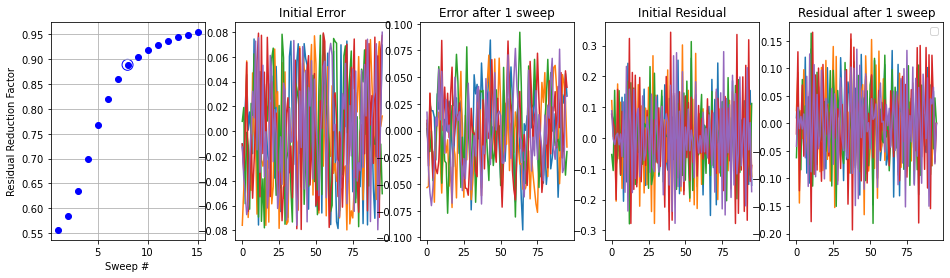

In [468]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95)
num_sweeps = method_info["relax"][1]

In [469]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 4 TVs with 30 sweeps
INFO     RER 0.192


### Coarsening: Fixed (4/2)

In [470]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

# Optimize aggregate_size, num_components using mock cycle rates.
# coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
#     level, x, num_sweeps, repetitive=repetitive)
# info = coarsener.get_coarsening_info(1, fmt="dataframe")
# r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
#     coarsener.get_optimal_coarsening(1)
# _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
#              "eff {:.2f}".format(
#     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
# coarsener.get_coarsening_info(1, fmt="dataframe")

,0,1,2,3
0,-0.29,-0.50,-0.60,-0.56
1,0.73,0.36,-0.12,-0.57


nu 100 s [1.    0.42  0.028 0.003] Energy error [0.388 0.026 0.003 0.   ]
INFO     Mock cycle conv [0.606 0.331 0.186 0.142 0.145 0.13  0.088 0.065 0.065 0.059 0.054]


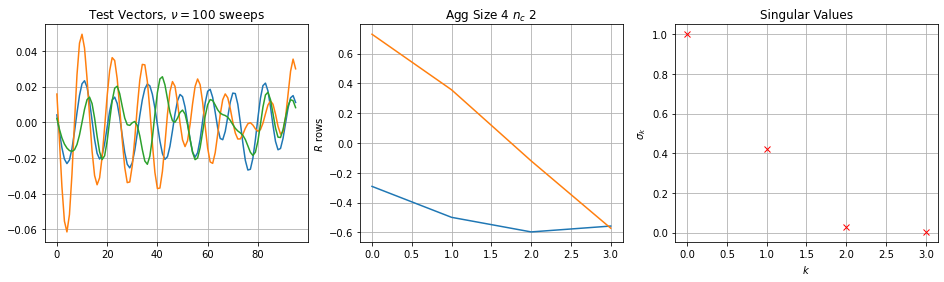

In [471]:
plot_svd_coarsening_accuracy(level, 100, aggregate_size, num_components)

,0,1,2,3,4,5,6,7,8,9
0,-0.38,-0.53,-0.58,-0.49,0.00,0.00,0.00,0.00,0.00,0.00
1,0.66,0.33,-0.17,-0.66,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,-0.38,-0.53,-0.58,-0.49,0.00,0.00
3,0.00,0.00,0.00,0.00,0.66,0.33,-0.17,-0.66,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.38,-0.53


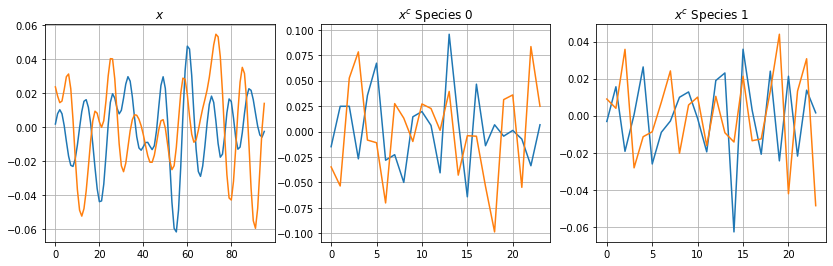

In [472]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Local Mock Cycle (LMC) Rate
The mock cycle rate is calculated on a domain of size $4 a$, $a$ = aggregate size.

In [473]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, num_sweeps + 1)
mock_conv = hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=16 [0.536 0.307 0.164 0.122 0.142 0.105 0.085 0.066]


### Interpolation $P = R^T$

In [474]:
# Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy(
            kh, discretization, m * aggregate_size, r.asarray(), p, aggregate_size, num_components), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(n // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(multilevel[0].a)).todense(), ord=2)))

INFO     L2 projection norm 1.00 A*A' projection norm 2.79


### Interpolation by LS Fitting

In [475]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))
        ml = hm.repetitive.locality.create_two_level_hierarchy(
                kh, discretization, n, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=2)
display_html(styler._repr_html_(), raw=True)

,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
Mock,nan,nan,nan,nan,nan,0.54,0.31,0.16,0.12,0.14,0.10,0.08,0.07
P=R^T,nan,nan,nan,nan,nan,0.54,0.39,0.48,0.48,0.45,0.45,0.44,0.43
P^T A P caliber 2,0.00,2.00,192.00,1.20,0.00,0.53,0.36,0.44,0.48,0.42,0.41,0.42,0.40
P^T A P caliber 3,0.00,3.00,288.00,1.40,0.00,0.62,0.32,0.27,0.32,0.31,0.26,0.23,0.23
P^T A P caliber 4,0.00,4.00,384.00,2.00,0.00,0.60,0.33,0.21,0.15,0.16,0.14,0.10,0.08
R A P caliber 2,1.00,2.00,192.00,1.20,0.04,0.53,0.38,0.46,0.48,0.42,0.40,0.42,0.40
R A P caliber 3,1.00,3.00,288.00,1.20,0.02,0.61,0.33,0.27,0.33,0.30,0.26,0.26,0.26
R A P caliber 4,1.00,4.00,384.00,1.20,0.01,0.69,0.37,0.29,0.21,0.16,0.14,0.10,0.07


* The SVD intepolation is good up to $\nu = 2$, conv $\approx 0.36$. This is similar to the case of Laplace + 2/1 coarsening, where $P$ is only first-order.
* Caliber 2 is equivalent to $P = R^T$.
* Caliber 3 is insufficient, oonly gives marginally better convergence than $P = R^T$.
* Caliber 4 Galerkin gives ideal rates (up to $0.11$).
* Caliber 4 $P$ with $R A P$ is slightly non-symmetric but sparser than $P^T A P$. It gives an intermediate performance between $R A R^R$ and $P^T A P$ (up to $0.18$). 

In [476]:
for use_r_as_restriction in (False, True):
    print("R*A*P" if use_r_as_restriction else "P^T*A*P")

    for caliber, p in zip(calibers, p_experiment[use_r_as_restriction]):
    #    styler = pd.DataFrame(p[:8, :8].todense()).style.set_table_attributes("style='display:inline'").set_caption("Caliber {}".format(caliber)).format(precision=2)   
    #    display_html(styler._repr_html_(), raw=True)
        ml = hm.repetitive.locality.create_two_level_hierarchy(kh, discretization, n, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        print("caliber {} P".format(caliber))
        display(pd.DataFrame(p[:aggregate_size, np.unique(p[:aggregate_size].nonzero()[1])].todense()))
        print("A^1")
        display(pd.DataFrame(ac[:num_components, np.unique(ac[:num_components].nonzero()[1])].todense()))
        #ac2 = ac.transpose().dot(ac)
        #display(pd.DataFrame(ac2.todense()[:14,:14]))

P^T*A*P
caliber 2 P


,0,1
0,-0.38,0.68
1,-0.53,0.30
2,-0.58,-0.18
3,-0.49,-0.64


A^1


,0,1,2,3,4,5
0,-0.19,-0.12,0.21,-0.40,0.21,0.28
1,-0.12,-1.45,0.28,-0.55,-0.40,-0.55


caliber 3 P


,0,1,2,3
0,-0.39,0.56,0.00,-0.08
1,-0.53,0.39,0.00,0.06
2,-0.58,-0.28,0.06,0.00
3,-0.49,-0.53,-0.06,0.00


A^1


,0,1,2,3,4,5,6,7
0,-0.09,-0.08,0.17,-0.29,0.01,0.01,0.17,0.21
1,-0.08,-1.08,0.21,-0.36,0.00,0.00,-0.29,-0.36


caliber 4 P


,0,1,2,3,4,5
0,-0.34,0.45,0.00,0.00,-0.13,-0.17
1,-0.56,0.46,0.00,0.00,0.09,0.11
2,-0.63,-0.37,0.08,-0.13,0.00,0.00
3,-0.43,-0.42,-0.09,0.15,0.00,0.00


A^1


,0,1,2,3,4,5,6,7,8,9
0,-0.07,-0.07,0.16,-0.27,0.01,-0.02,0.01,0.01,0.16,0.20
1,-0.07,-0.97,0.20,-0.35,0.01,-0.02,-0.02,-0.02,-0.27,-0.35


R*A*P
caliber 2 P


,0,1
0,-0.38,0.68
1,-0.53,0.30
2,-0.58,-0.18
3,-0.49,-0.64


A^1


,0,1,2,3,4,5
0,-0.19,-0.11,0.21,-0.40,0.21,0.29
1,-0.13,-1.44,0.29,-0.57,-0.39,-0.53


caliber 3 P


,0,1,2,3
0,-0.39,0.56,0.00,-0.08
1,-0.53,0.39,0.00,0.06
2,-0.58,-0.28,0.06,0.00
3,-0.49,-0.53,-0.06,0.00


A^1


,0,1,2,3,4,5
0,-0.11,-0.10,0.19,-0.32,0.19,0.24
1,-0.10,-1.18,0.22,-0.46,-0.30,-0.44


caliber 4 P


,0,1,2,3,4,5
0,-0.34,0.45,0.00,0.00,-0.13,-0.17
1,-0.56,0.46,0.00,0.00,0.09,0.11
2,-0.63,-0.37,0.08,-0.13,0.00,0.00
3,-0.43,-0.42,-0.09,0.15,0.00,0.00


A^1


,0,1,2,3,4,5
0,-0.04,-0.05,0.15,-0.19,0.15,0.14
1,-0.05,-0.64,0.15,-0.16,-0.20,-0.17


In [477]:
# Pick an interpolation operator P:1->0 to work with. We use a high-order (caliber 4) P.
p = p_experiment[True][-1]  # R*A*P P high order
#p = p_experiment[True][0]  # R*A*P P=R^T

### Solving $Ax = b$ - Convergence History

#### $P^T A P$

INFO         0 |r| 1.916e+01 RER 3.81286
INFO         1 |r| 3.309e+00 (0.17270) RER 0.03792 (0.00995) 87.250
INFO         2 |r| 7.220e-01 (0.21819) RER 0.00789 (0.20800) 91.524
INFO         3 |r| 1.048e-01 (0.14518) RER 0.00114 (0.14406) 92.231
INFO         4 |r| 2.262e-02 (0.21581) RER 0.00025 (0.21569) 92.281
INFO         5 |r| 3.858e-03 (0.17057) RER 0.00004 (0.17055) 92.290
INFO         6 |r| 7.935e-04 (0.20565) RER 0.00001 (0.20566) 92.289
INFO         7 |r| 1.554e-04 (0.19591) RER 0.00000 (0.19591) 92.288
INFO         8 |r| 3.191e-05 (0.20531) RER 0.00000 (0.20531) 92.288
INFO         9 |r| 6.642e-06 (0.20810) RER 0.00000 (0.20810) 92.288
INFO        10 |r| 1.387e-06 (0.20884) RER 0.00000 (0.20884) 92.288
INFO        11 |r| 2.969e-07 (0.21405) RER 0.00000 (0.21405) 92.288
INFO        12 |r| 6.293e-08 (0.21195) RER 0.00000 (0.21195) 92.288
INFO        13 |r| 1.341e-08 (0.21308) RER 0.00000 (0.21308) 92.288
INFO        14 |r| 2.847e-09 (0.21235) RER 0.00000 (0.21235) 92.288
INFO   

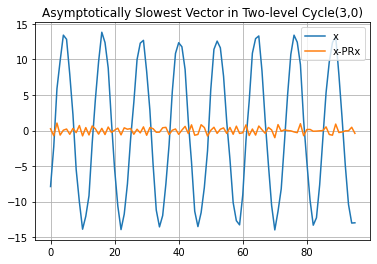

In [485]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 3
use_r_as_restriction = False

m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
y -= y.mean() # Remove zero component.
e = y - m0[1].p.dot(m0[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [486]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [-0.    -0.     0.064  0.064 -0.073 -0.073  0.121  0.121 -0.154 -0.154  0.168  0.168]


#### $P^T A Q$ Coarsening
This is not exactly a matrix multiplication $P^T A Q$, since $Q$ is not a uni-valued operator. It maps a point at the edge of the stencil of $P^T A$ to two values, one when it's at the edge and one when it's in the middle of the stencil.

In [518]:
fine_level, coarse_level = m0[0:2]
p = coarse_level.p
r = coarse_level.r
ac = coarse_level.a

caliber = 4
ptaq = hm.repetitive.coarsening_repetitive.create_ptaq_matrix(
    fine_level,
    fine_level.location,
    x,
    coarse_level,
    coarse_level.location,
    aggregate_size,
    num_components,
    caliber)

print("Symmetry", np.max(np.abs(ptaq - ptaq.transpose())))

# Calculate eigenpairs at all levels.
coarse_level.a = ac
laml, vl = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])
    
coarse_level.a = ptaq    
laml2, vl2 = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml2[1:]):
    print(l, "lam", lam[:12])

Symmetry 0.047483370100805
0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [ 0.002  0.002  0.067  0.067 -0.073 -0.073  0.123  0.123 -0.159 -0.159  0.17   0.17 ]
0 lam [ 0.002  0.002  0.067  0.067 -0.073 -0.073  0.123  0.123 -0.159 -0.159  0.17   0.17 ]


In [565]:
ap = fine_level.a.dot(coarse_level.p)
# Arbitrarily use the first aggregate in the domain as the center of P^T*A.
pt = coarse_level.p.transpose()
pt_vars = np.unique(pt[:num_components].nonzero()[1])
ap_vars = np.unique(ap[pt_vars].todense().nonzero()[1])

# Calculate 'rap_vars' = target sparsity pattern = P^T*A*R^T sparsity pattern.
rap = coarse_level.r.dot(ap)
rap_vars = np.unique(rap[:num_components].nonzero()[1])

q = hm.repetitive.coarsening_repetitive._create_q_interpolation_matrix(fine_level, fine_level.location, x, coarse_level, coarse_level.location,
                                   6, aggregate_size, num_components, caliber, ap_vars, rap_vars,
                                   num_test_examples=5)


In [579]:
pt_vars, rap_vars, ap_vars, q, q.transpose()[:num_components].shape

(array([ 0,  1,  2,  3,  4,  5, 94, 95], dtype=int32),
 array([ 0,  1,  2,  3, 46, 47], dtype=int32),
 array([ 0,  1,  2,  3,  4,  5, 44, 45, 46, 47]),
 <10x6 sparse matrix of type '<class 'numpy.float64'>'
 	with 40 stored elements in Compressed Sparse Row format>,
 (2, 10))

In [595]:
np.unique(ap[np.array([0, 1, 2, 3, 94, 95])].todense().nonzero()[1])

array([ 0,  1,  2,  3, 44, 45, 46, 47])

In [592]:
pd.DataFrame(ap[pt_vars][:, ap_vars].todense())

,0,1,2,3,4,5,6,7,8,9
0,-0.05,-0.14,-0.01,0.01,0.00,0.00,0.00,0.00,-0.11,-0.00
1,-0.01,-0.90,0.11,-0.18,0.00,0.00,0.00,0.00,-0.34,-0.44
2,0.12,0.86,-0.26,0.45,0.00,0.00,0.00,0.00,0.13,0.16
3,-0.01,0.16,-0.11,0.05,0.00,0.00,0.00,0.00,-0.01,-0.01
4,-0.11,-0.00,-0.05,-0.14,-0.01,0.01,0.00,0.00,0.00,0.00
5,-0.34,-0.44,-0.01,-0.90,0.11,-0.18,0.00,0.00,0.00,0.00
6,-0.26,0.45,0.00,0.00,0.00,0.00,0.13,0.16,0.12,0.86
7,-0.11,0.05,0.00,0.00,0.00,0.00,-0.01,-0.01,-0.01,0.16


In [535]:
    rap = coarse_level.r.dot(ap)
rap_vars = np.unique(rap[:num_components].nonzero()[1])
rap_vars

array([ 0,  1,  2,  3, 46, 47], dtype=int32)

In [530]:
pt_vars

array([ 0,  1,  2,  3,  4,  5, 94, 95], dtype=int32)

In [513]:
y = vl[0][:, 1]
y2 = vl[1][:, 1]

/Users/olivne/opt/miniconda3/envs/hm/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


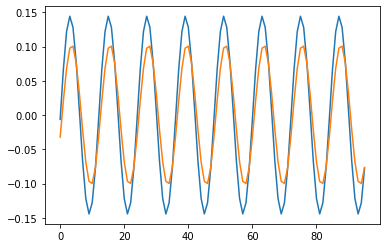

In [514]:
plt.plot(y)
plt.plot(y2)

INFO         0 |r| 1.733e+01 RER 2.83066
INFO         1 |r| 2.072e+00 (0.11954) RER 0.04234 (0.01496) 48.933
INFO         2 |r| 2.993e-01 (0.14446) RER 0.00563 (0.13296) 53.166
INFO         3 |r| 3.406e-02 (0.11380) RER 0.00064 (0.11382) 53.159
INFO         4 |r| 4.555e-03 (0.13375) RER 0.00009 (0.13391) 53.095
INFO         5 |r| 6.853e-04 (0.15044) RER 0.00001 (0.15048) 53.083
INFO         6 |r| 1.038e-04 (0.15154) RER 0.00000 (0.15154) 53.083
INFO         7 |r| 1.616e-05 (0.15559) RER 0.00000 (0.15559) 53.084
INFO         8 |r| 2.537e-06 (0.15701) RER 0.00000 (0.15701) 53.084
INFO         9 |r| 3.981e-07 (0.15691) RER 0.00000 (0.15691) 53.084
INFO        10 |r| 6.349e-08 (0.15949) RER 0.00000 (0.15949) 53.084
INFO        11 |r| 1.017e-08 (0.16025) RER 0.00000 (0.16025) 53.084
INFO        12 |r| 1.638e-09 (0.16102) RER 0.00000 (0.16102) 53.084
INFO        13 |r| 2.652e-10 (0.16186) RER 0.00000 (0.16186) 53.084
INFO        14 |r| 4.234e-11 (0.15969) RER 0.00000 (0.15969) 53.084


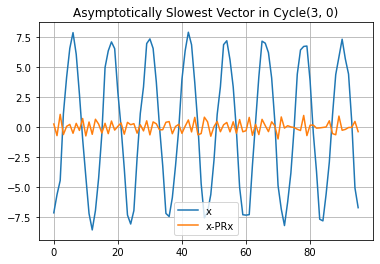

In [517]:
coarse_level.a = ptaq
nu_pre = 3
nu_post = 1
y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu_pre, nu_post=nu_post, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Cycle({}, 0)".format(nu_pre, nu_post))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [516]:
coarse_level.a - coarse_level.a.transpose()

<48x48 sparse matrix of type '<class 'numpy.float64'>'
	with 240 stored elements in Compressed Sparse Row format>

## Level 1->2 Coarsening
Are the equations at level 1 harder to solve than level 0 because of worse smoothing rates? Do we see a good coarsening ratio for an aggregate of size $4$ here too?

In [443]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

num_sweeps_on_vectors = 30 # 100

## Level 1 Relaxation

We run relaxation on $A x = 0$. $A$ has two null vectors; call $Y$ the $n \times 2$ matrix whose columns are these vectors. Let $x_0$ be a random[-1, 1] initial guess for $x$. We first project $x_0$ onto the range of $A$, that is,

$x_0 \longleftarrow x_0 - Y Y^T x_0^T\,,$

and use this as the initial guess for the run. Since the magnitude of $Y$ the exact solution is $0$, and relaxation doesn't change this magnitude, $e = x - x_0$ is a meaningful definition, which can also be used to calculate a meaningful RER.

In [444]:
m1 = m0.sub_hierarchy(1)
level = m1.finest_level
a = level.a

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     3.325e-01                    4.468e-01    0.747
INFO     1     1.343e-01 (0.418) [0.418]    2.844e-01    0.476 (0.659)
INFO     2     6.442e-02 (0.487) [0.445]    2.229e-01    0.296 (0.626)
INFO     3     3.988e-02 (0.622) [0.497]    1.981e-01    0.206 (0.701)
INFO     4     2.988e-02 (0.749) [0.550]    1.825e-01    0.168 (0.817)
INFO     5     2.379e-02 (0.795) [0.592]    1.718e-01    0.142 (0.847)
INFO     6     1.988e-02 (0.835) [0.627]    1.641e-01    0.124 (0.877)
INFO     7     1.717e-02 (0.862) [0.656]    1.580e-01    0.112 (0.897)
INFO     8     1.521e-02 (0.884) [0.681]    1.532e-01    0.102 (0.914)
INFO     9     1.373e-02 (0.901) [0.703]    1.491e-01    0.095 (0.928)
INFO     10    1.258e-02 (0.915) [0.722]    1.455e-01    0.089 (0.939)
INFO     11    1.166e-02 (0.925) [0.738]    1.424e-01    0.085 (0.947)
INFO     12    1.089e-02 (0.933) [0.753]    1.397e-01    0.081 (0.953)
INFO 

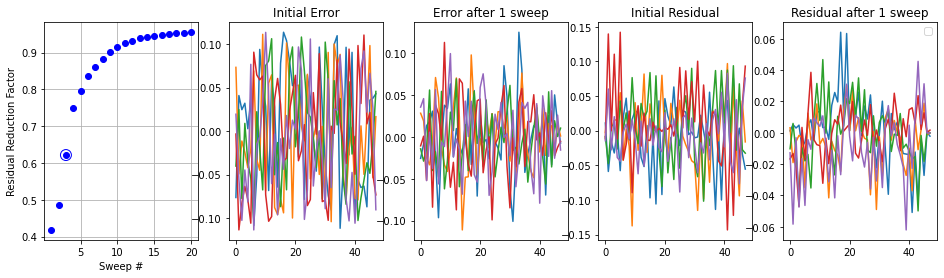

In [445]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["relax"][1]

,0,1,2,3
0,0.66,-0.09,-0.62,-0.42
1,-0.29,-0.84,-0.37,0.28


nu 100 s [1.    0.834 0.341 0.228] Energy error [0.681 0.301 0.167 0.   ]
INFO     Mock cycle conv [0.44  0.438 0.355 0.3   0.251 0.212 0.164 0.146 0.119 0.112 0.105]


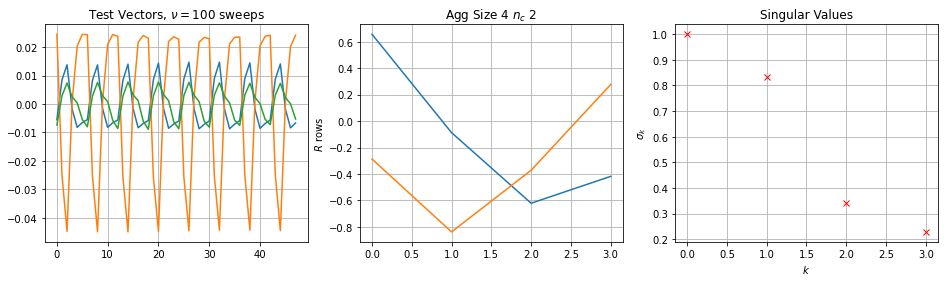

In [446]:
# #PCs revealed by relaxed vectors of increasing smoothness.
plot_svd_coarsening_accuracy(level, 100, aggregate_size, num_components)

In [447]:
pd.DataFrame(level.a.todense()[10:12, 8:14])

,0,1,2,3,4,5
0,0.15,0.16,-0.05,-0.06,0.16,-0.22
1,-0.27,-0.28,-0.06,-0.92,0.20,-0.28


In [448]:
ideal_tv = False # True
num_examples = 5
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 5 TVs with 30 sweeps
INFO     RER 0.071


In [449]:
#plt.plot(x[:, 0][1::2])
#plt.plot(x[:, 1][1::2])
#plt.plot(x[:, 2][1::2])

#plt.plot(x[:, 1])

In [450]:
# def autocorr(x):
#     result = np.correlate(x, x, mode='full')
#     return result[result.size//2:]

In [451]:
 # np.correlate(x[:, 0], x[:, 0], mode='full')

[1.    0.875 0.267 0.122]
(24, 48)


,0,1,2,3,4,5,6,7,8,9
0,-0.60,-0.37,0.35,0.61,0.00,0.00,0.00,0.00,0.00,0.00
1,0.19,-0.62,-0.73,0.22,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,-0.60,-0.37,0.35,0.61,0.00,0.00
3,0.00,0.00,0.00,0.00,0.19,-0.62,-0.73,0.22,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.60,-0.37


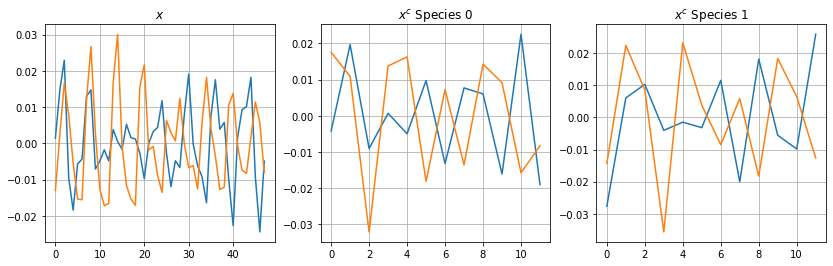

In [452]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
print(s/s[0])
R = r.tile(level.size // aggregate_size)
print(R.shape)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Mock Cycle Rate

In [453]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, 12)
mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values])
#hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=16 [0.453 0.474 0.377 0.339 0.286 0.243 0.205 0.17  0.132 0.117 0.1  ]


In [454]:
# hm.setup.geometry.geometric_neighbors_from_locations(location[0], location[1], n, aggregate_size)[:, :4]
# num_aggregates = int(np.ceil(multilevel[0].a.shape[0] / aggregate_size))
# num_coarse_vars = nc * num_aggregates
# np.mod(hm.setup.geometry.geometric_neighbors(aggregate_size, num_components), num_coarse_vars)

### Interpolation $P = R^T$

In [455]:
#### Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
            level.a, level.location, r.asarray(), p, aggregate_size, num_components), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(level.size // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(level.a)).todense(), ord=2)))

INFO     L2 projection norm 1.00 A*A' projection norm 0.83


### Interpolation by LS Fitting

In [456]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        #print(a.shape, R.shape, level.location.shape)
        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))
        ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
                level.a, level.location, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=2)
display_html(styler._repr_html_(), raw=True)

,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,nan,nan,nan,0.45,0.47,0.38,0.34,0.29,0.24,0.20,0.17,0.13,0.12,0.10
P=R^T,nan,nan,nan,nan,nan,1.20,1.02,0.91,0.86,0.95,0.95,0.95,0.94,0.94,0.94,0.94
P^T A P caliber 2,0.00,2.00,96.00,1.00,0.02,2.02,1.66,1.49,1.37,1.22,1.08,0.97,0.86,0.76,0.67,0.58
P^T A P caliber 3,0.00,3.00,144.00,1.17,0.01,0.41,0.27,0.13,0.14,0.14,0.13,0.13,0.13,0.12,0.12,0.12
P^T A P caliber 4,0.00,4.00,192.00,1.67,0.01,6.15,3.99,2.17,1.13,1.17,0.89,0.69,0.53,0.46,0.38,0.32
R A P caliber 2,1.00,2.00,96.00,1.00,0.11,1.55,1.27,1.22,1.03,0.95,0.87,0.85,0.84,0.84,0.83,0.83
R A P caliber 3,1.00,3.00,144.00,1.00,0.09,1.91,1.55,1.39,1.22,1.06,0.82,0.81,0.71,0.61,0.53,0.47
R A P caliber 4,1.00,4.00,192.00,1.00,0.02,0.43,0.42,0.43,0.43,0.44,0.43,0.44,0.44,0.44,0.44,0.44


### Solving $Ax = b$ - Convergence History

INFO         0 |r| 4.705e+00 RER 1.23970
INFO         1 |r| 5.933e+00 (1.26114) RER 0.40393 (0.32583) 14.689
INFO         2 |r| 2.930e+01 (4.93730) RER 0.41819 (1.03530) 70.053
INFO         3 |r| 1.424e+02 (4.86210) RER 0.42211 (1.00937) 337.441
INFO         4 |r| 5.939e+02 (4.16989) RER 0.42369 (1.00375) 1401.832
INFO         5 |r| 2.125e+03 (3.57818) RER 0.42422 (1.00123) 5009.822
INFO         6 |r| 6.514e+03 (3.06499) RER 0.42311 (0.99741) 15394.967
INFO         7 |r| 1.793e+04 (2.75286) RER 0.41791 (0.98771) 42907.650
INFO         8 |r| 6.359e+04 (3.54629) RER 0.41352 (0.98948) 153780.523
INFO         9 |r| 3.250e+05 (5.11031) RER 0.41839 (1.01179) 776712.151
INFO        10 |r| 1.568e+06 (4.82639) RER 0.42196 (1.00853) 3717025.081
INFO        11 |r| 6.492e+06 (4.13937) RER 0.42367 (1.00405) 15324129.020
INFO        12 |r| 2.306e+07 (3.55200) RER 0.42419 (1.00123) 54364244.499
INFO        13 |r| 7.017e+07 (3.04272) RER 0.42298 (0.99715) 165887734.806
INFO        14 |r| 1.932e+08 (2.

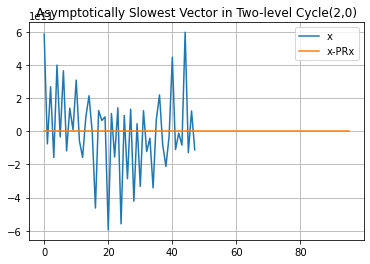

In [457]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 2
p = p_experiment[False][-1]  # P^T*A*P P high order
use_r_as_restriction = False

m1 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(m1, nu, print_frequency=1,
                                                    debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [458]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m1)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

0 lam [ 0.002  0.002  0.067  0.067 -0.073 -0.073  0.123  0.123 -0.159 -0.159  0.17   0.17 ]
1 lam [ 0.001  0.001  0.003  0.003 -0.014  0.042  0.042  0.057  0.057  0.072  0.103  0.103]


## 3-Level Method

In [459]:
m0.add(m1[1])

INFO         0 |r| 1.754e+01 RER 3.27963
INFO         1 |r| 6.204e+00 (0.35375) RER 0.43256 (0.13189) 14.341
INFO         2 |r| 9.503e+00 (1.53194) RER 0.39221 (0.90672) 24.230
INFO         3 |r| 1.268e+01 (1.33375) RER 0.39166 (0.99859) 32.363
INFO         4 |r| 1.490e+01 (1.17516) RER 0.41277 (1.05391) 36.086
INFO         5 |r| 1.488e+01 (0.99867) RER 0.42400 (1.02719) 35.084
INFO         6 |r| 1.193e+01 (0.80199) RER 0.35628 (0.84029) 33.485
INFO         7 |r| 6.773e+00 (0.56777) RER 0.18738 (0.52592) 36.149
INFO         8 |r| 2.205e+00 (0.32551) RER 0.05383 (0.28726) 40.963
INFO         9 |r| 5.209e+00 (2.36243) RER 0.12025 (2.23415) 43.315
INFO        10 |r| 8.954e+00 (1.71908) RER 0.20770 (1.72721) 43.111
INFO        11 |r| 1.223e+01 (1.36620) RER 0.27858 (1.34123) 43.914
INFO        12 |r| 1.487e+01 (1.21531) RER 0.30941 (1.11067) 48.051
INFO        13 |r| 1.558e+01 (1.04814) RER 0.28201 (0.91145) 55.257
INFO        14 |r| 1.332e+01 (0.85499) RER 0.20411 (0.72377) 65.275
INFO   

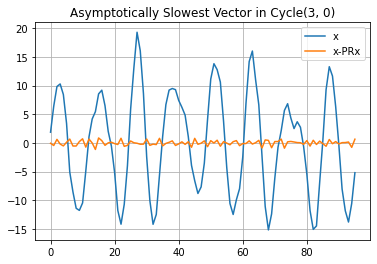

In [460]:
nu_pre = 3
nu_post = 2
y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu_pre, nu_post=nu_post, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Cycle({}, 0)".format(nu_pre, nu_post))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [461]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

0 lam [ 0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [ 0.002  0.002  0.067  0.067 -0.073 -0.073  0.123  0.123 -0.159 -0.159  0.17   0.17 ]
2 lam [ 0.001  0.001  0.003  0.003 -0.014  0.042  0.042  0.057  0.057  0.072  0.103  0.103]


In [462]:
# Save A^1 to file.
#scipy.sparse.save_npz('level_1_operator.npz', m0[1].a)